# **AntiMicrobial Resistance Prediction from SNPs**

This notebook contains the end-to-end Explainable Random Forest implementation of **AMR Prediction from SNPs** project. Feel free to use/customise the code.

##**Setup & Imports**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# --- Scikit-learn Imports ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef, roc_auc_score
)

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"

# Data Splitting Ratios
TEST_SPLIT = 0.2

# Seed for reproducibility
np.random.seed(42)

print("Setup Complete. Using Scikit-learn for Random Forest.")

Setup Complete. Using Scikit-learn for Random Forest.


# **CIP**

In [24]:
TARGET_ANTIBIOTIC = "CIP"

## **Initial Preprocessing**

In [25]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data for the target antibiotic
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Storing original SNP position names for explainability
snp_position_names = features_df.columns.tolist()

# Converting features to NumPy array
X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 366, Susceptible (0): 443


# **Data Splitting**

In [26]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


## **Model Definition & Training**

In [27]:
print("\n--- Defining and Training the Random Forest Model ---")

# --- Hyperparameter Selection based on Theoretical Knowledge ---
# n_estimators: The number of trees in the forest. 300-500 is a common choice.
n_estimators = 400

# For high-dimensional data, limiting depth prevents individual trees from overfitting, so I went with that.
max_depth = 15

# max_features: The number of features to consider when looking for the best split.
max_features = 'sqrt'

class_weight = 'balanced'

# n_jobs: Number of jobs to run in parallel. -1 means using all available CPU cores.
n_jobs = -1

# --- Model Instantiation ---
rf_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features,
    class_weight=class_weight,
    n_jobs=n_jobs,
    random_state=42,
    oob_score=True # Using out-of-bag samples to estimate generalization accuracy
)

print(f"Training Random Forest with {n_estimators} trees and max_depth={max_depth}...")
rf_model.fit(X_train, y_train)

# --- Out-of-Bag Score ---
print(f"\nModel Out-of-Bag (OOB) Score: {rf_model.oob_score_:.4f}")

# --- SAVING THE FINAL MODEL ---
RF_MODEL_PATH = "best_RF_model_CIP.pkl"
print(f"Saving the final Random Forest model to {RF_MODEL_PATH}...")
joblib.dump(rf_model, RF_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the Random Forest Model ---
Training Random Forest with 400 trees and max_depth=15...

Model Out-of-Bag (OOB) Score: 0.9119
Saving the final Random Forest model to best_RF_model_CIP.pkl...
Model saved successfully.


# **Model Evaluation**


--- Evaluating Random Forest Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.9568
AUC Score: 0.9769
Cohen's Kappa: 0.9126
Matthews Correlation Coefficient (MCC): 0.9127

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.9556    0.9663    0.9609        89
  Resistant (1)     0.9583    0.9452    0.9517        73

       accuracy                         0.9568       162
      macro avg     0.9569    0.9557    0.9563       162
   weighted avg     0.9568    0.9568    0.9568       162


Confusion Matrix:


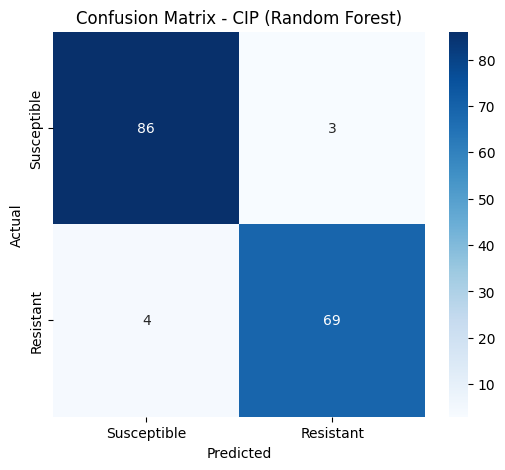

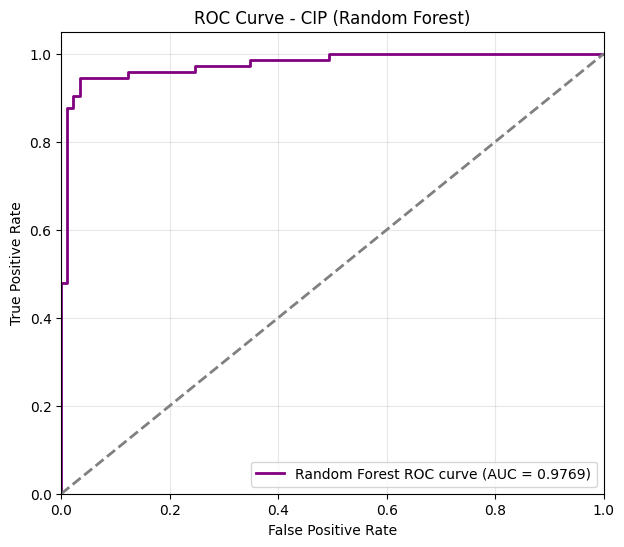

In [28]:
print("\n--- Evaluating Random Forest Model on Test Set ---")

# --- Making Predictions ---
y_pred_rf = rf_model.predict(X_test)
y_pred_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# --- Calculating All Metrics ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_probs_rf)
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"AUC Score: {auc_rf:.4f}")
print(f"Cohen's Kappa: {kappa_rf:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_rf:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_test, y_pred_rf, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.show()

# --- ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_probs_rf)
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest ROC curve (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- Random Forest Explainability: Feature Importances ---
Top 10 most important SNP positions for predicting CIP resistance:
      SNP_Position  Importance
14389     X4441501    0.004034
60363   X4441501.3    0.003386
29264   X4477553.1    0.003137
41989   X3538947.2    0.003023
45591   X4458732.2    0.002991
44741   X4271406.2    0.002838
13576     X4230581    0.002759
45421   X4428463.2    0.002721
59136   X4101302.3    0.002515
28428   X4271406.1    0.002494


/tmp/ipython-input-1486057161.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')


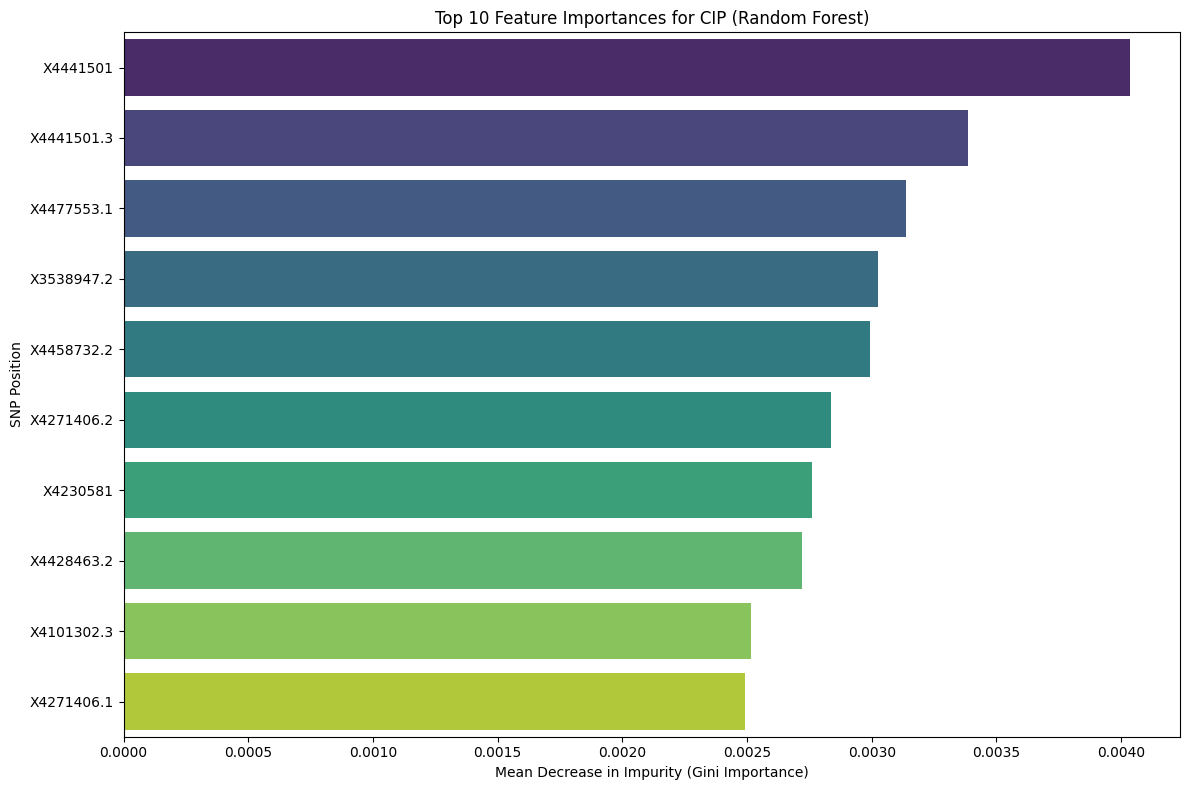


--- Explainability Analysis Complete ---
Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.


In [29]:
print("\n--- Random Forest Explainability: Feature Importances ---")

# Getting feature importances from the trained model
importances = rf_model.feature_importances_

# Creating a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'SNP_Position': snp_position_names,
    'Importance': importances
})

# Sorting the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# --- Displaying and Plotting Top Features ---
top_n = 10 # Number of top features to display
print(f"Top {top_n} most important SNP positions for predicting {TARGET_ANTIBIOTIC} resistance:")
print(feature_importance_df.head(top_n))

# Creating a bar plot of the top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Feature Importances for {TARGET_ANTIBIOTIC} (Random Forest)')
plt.xlabel('Mean Decrease in Impurity (Gini Importance)')
plt.ylabel('SNP Position')
plt.tight_layout()
plt.show()

print("\n--- Explainability Analysis Complete ---")
print("Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.")

# **CTX**

In [30]:
TARGET_ANTIBIOTIC = "CTX"

## **Initial Preprocessing**

In [31]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data for the target antibiotic
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Storing original SNP position names for explainability
snp_position_names = features_df.columns.tolist()

# Converting features to NumPy array
X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 358, Susceptible (0): 451


# **Data Splitting**

In [32]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


## **Model Definition & Training**

In [33]:
print("\n--- Defining and Training the Random Forest Model ---")

# --- Hyperparameter Selection based on Theoretical Knowledge ---
# n_estimators: The number of trees in the forest. 300-500 is a common choice.
n_estimators = 400

# For high-dimensional data, limiting depth prevents individual trees from overfitting, so I went with that.
max_depth = 15

# max_features: The number of features to consider when looking for the best split.
max_features = 'sqrt'

class_weight = 'balanced'

# n_jobs: Number of jobs to run in parallel. -1 means using all available CPU cores.
n_jobs = -1

# --- Model Instantiation ---
rf_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features,
    class_weight=class_weight,
    n_jobs=n_jobs,
    random_state=42,
    oob_score=True # Using out-of-bag samples to estimate generalization accuracy
)

print(f"Training Random Forest with {n_estimators} trees and max_depth={max_depth}...")
rf_model.fit(X_train, y_train)

# --- Out-of-Bag Score ---
print(f"\nModel Out-of-Bag (OOB) Score: {rf_model.oob_score_:.4f}")

# --- SAVING THE FINAL MODEL ---
RF_MODEL_PATH = "best_RF_model_CTX.pkl"
print(f"Saving the final Random Forest model to {RF_MODEL_PATH}...")
joblib.dump(rf_model, RF_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the Random Forest Model ---
Training Random Forest with 400 trees and max_depth=15...

Model Out-of-Bag (OOB) Score: 0.7589
Saving the final Random Forest model to best_RF_model_CTX.pkl...
Model saved successfully.


# **Model Evaluation**


--- Evaluating Random Forest Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.8025
AUC Score: 0.8719
Cohen's Kappa: 0.6033
Matthews Correlation Coefficient (MCC): 0.6050

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8452    0.7889    0.8161        90
  Resistant (1)     0.7564    0.8194    0.7867        72

       accuracy                         0.8025       162
      macro avg     0.8008    0.8042    0.8014       162
   weighted avg     0.8058    0.8025    0.8030       162


Confusion Matrix:


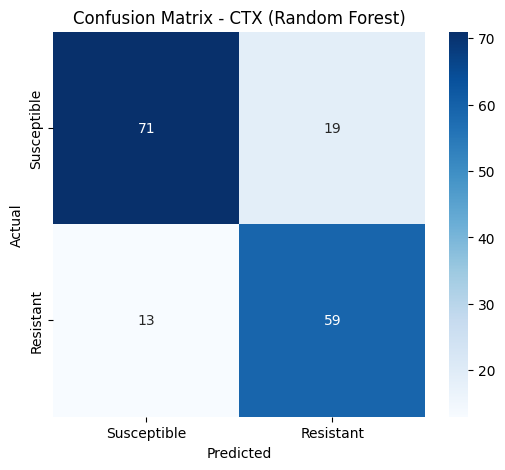

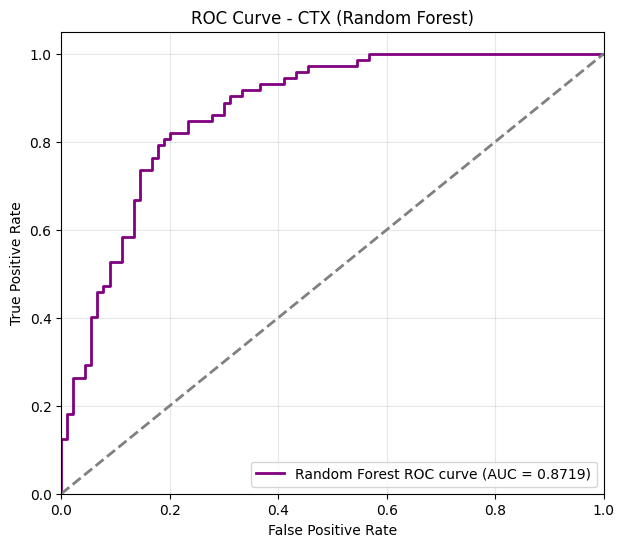

In [34]:
print("\n--- Evaluating Random Forest Model on Test Set ---")

# --- Making Predictions ---
y_pred_rf = rf_model.predict(X_test)
y_pred_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# --- Calculating All Metrics ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_probs_rf)
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"AUC Score: {auc_rf:.4f}")
print(f"Cohen's Kappa: {kappa_rf:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_rf:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_test, y_pred_rf, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.show()

# --- ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_probs_rf)
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest ROC curve (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- Random Forest Explainability: Feature Importances ---
Top 10 most important SNP positions for predicting CTX resistance:
      SNP_Position  Importance
11223     X3538947    0.002637
25724   X3436868.1    0.002535
41989   X3538947.2    0.001794
44170   X4114164.2    0.001615
38183   X2435798.2    0.001528
42401     X3642836    0.001521
36225   X2017588.2    0.001495
29098   X4443644.1    0.001484
13423     X4172893    0.001443
55360   X2914524.3    0.001420


/tmp/ipython-input-1486057161.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')


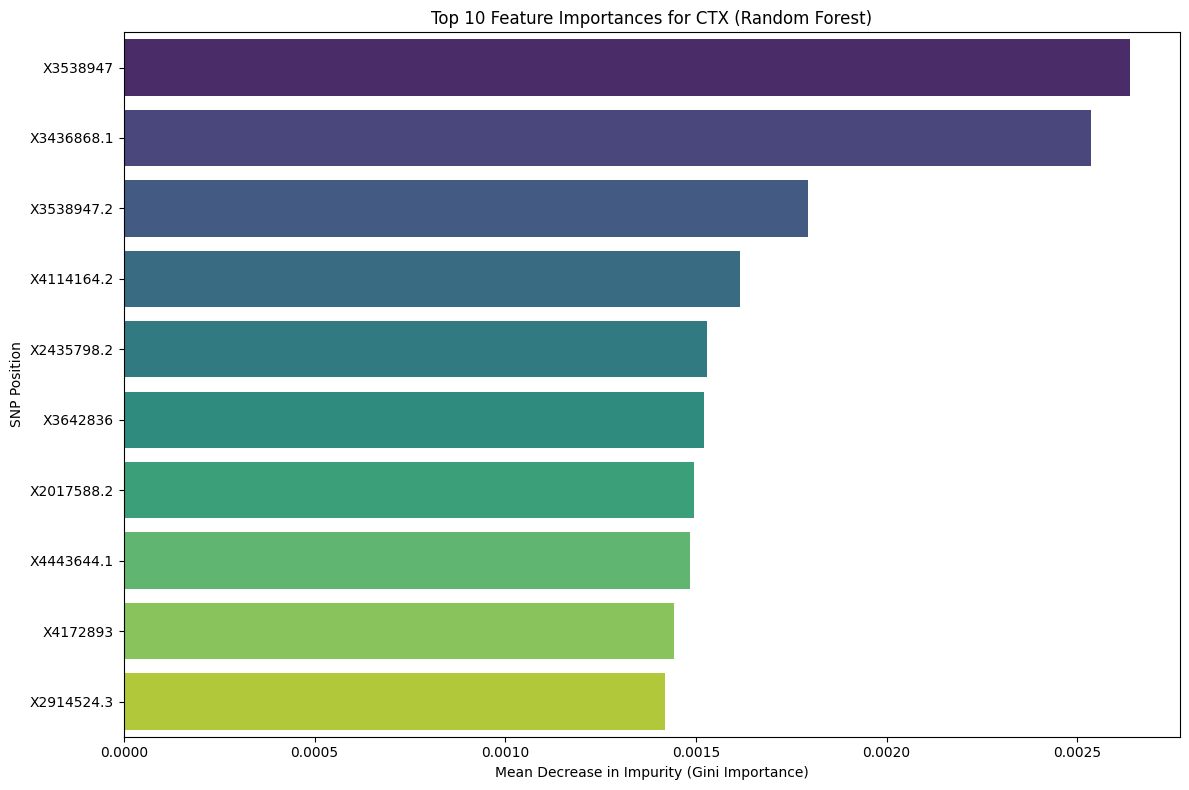


--- Explainability Analysis Complete ---
Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.


In [36]:
print("\n--- Random Forest Explainability: Feature Importances ---")

# Getting feature importances from the trained model
importances = rf_model.feature_importances_

# Creating a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'SNP_Position': snp_position_names,
    'Importance': importances
})

# Sorting the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# --- Displaying and Plotting Top Features ---
top_n = 10 # Number of top features to display
print(f"Top {top_n} most important SNP positions for predicting {TARGET_ANTIBIOTIC} resistance:")
print(feature_importance_df.head(top_n))

# Creating a bar plot of the top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Feature Importances for {TARGET_ANTIBIOTIC} (Random Forest)')
plt.xlabel('Mean Decrease in Impurity (Gini Importance)')
plt.ylabel('SNP Position')
plt.tight_layout()
plt.show()

print("\n--- Explainability Analysis Complete ---")
print("Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.")

# **CTZ**

In [12]:
TARGET_ANTIBIOTIC = "CTZ"

## **Initial Preprocessing**

In [13]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data for the target antibiotic
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Storing original SNP position names for explainability
snp_position_names = features_df.columns.tolist()

# Converting features to NumPy array
X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 276, Susceptible (0): 533


# **Data Splitting**

In [14]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


## **Model Definition & Training**

In [15]:
print("\n--- Defining and Training the Random Forest Model ---")

# --- Hyperparameter Selection based on Theoretical Knowledge ---
# n_estimators: The number of trees in the forest. 300-500 is a common choice.
n_estimators = 400

# For high-dimensional data, limiting depth prevents individual trees from overfitting, so I went with that.
max_depth = 15

# max_features: The number of features to consider when looking for the best split.
max_features = 'sqrt'

class_weight = 'balanced'

# n_jobs: Number of jobs to run in parallel. -1 means using all available CPU cores.
n_jobs = -1

# --- Model Instantiation ---
rf_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features,
    class_weight=class_weight,
    n_jobs=n_jobs,
    random_state=42,
    oob_score=True # Using out-of-bag samples to estimate generalization accuracy
)

print(f"Training Random Forest with {n_estimators} trees and max_depth={max_depth}...")
rf_model.fit(X_train, y_train)

# --- Out-of-Bag Score ---
print(f"\nModel Out-of-Bag (OOB) Score: {rf_model.oob_score_:.4f}")

# --- SAVING THE FINAL MODEL ---
RF_MODEL_PATH = "best_RF_model_CTZ.pkl"
print(f"Saving the final Random Forest model to {RF_MODEL_PATH}...")
joblib.dump(rf_model, RF_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the Random Forest Model ---
Training Random Forest with 400 trees and max_depth=15...

Model Out-of-Bag (OOB) Score: 0.8114
Saving the final Random Forest model to best_RF_model_CTZ.pkl...
Model saved successfully.


# **Model Evaluation**


--- Evaluating Random Forest Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.8210
AUC Score: 0.8178
Cohen's Kappa: 0.5955
Matthews Correlation Coefficient (MCC): 0.5960

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8545    0.8785    0.8664       107
  Resistant (1)     0.7500    0.7091    0.7290        55

       accuracy                         0.8210       162
      macro avg     0.8023    0.7938    0.7977       162
   weighted avg     0.8191    0.8210    0.8197       162


Confusion Matrix:


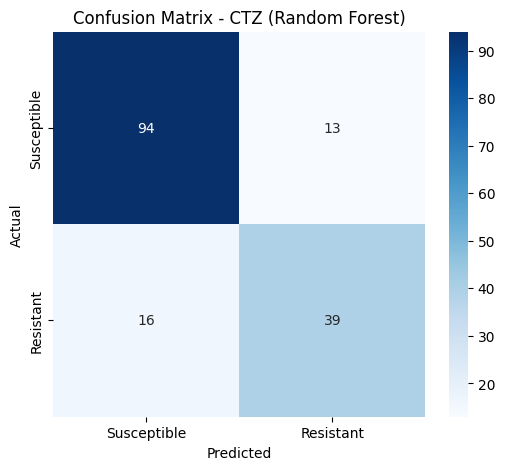

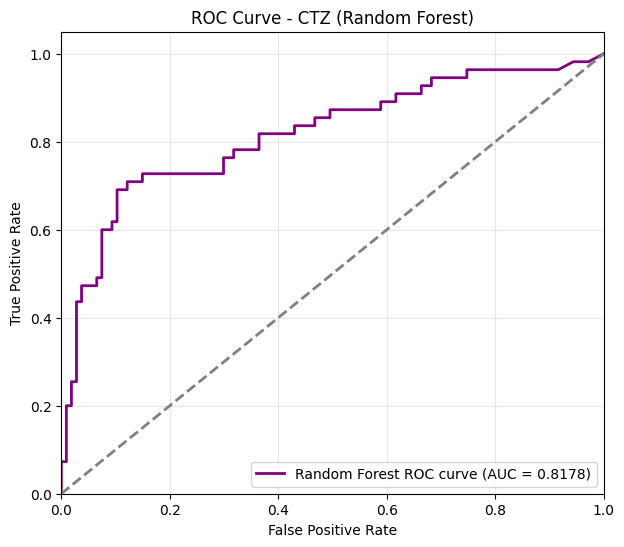

In [16]:
print("\n--- Evaluating Random Forest Model on Test Set ---")

# --- Making Predictions ---
y_pred_rf = rf_model.predict(X_test)
y_pred_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# --- Calculating All Metrics ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_probs_rf)
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"AUC Score: {auc_rf:.4f}")
print(f"Cohen's Kappa: {kappa_rf:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_rf:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_test, y_pred_rf, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.show()

# --- ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_probs_rf)
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest ROC curve (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- Random Forest Explainability: Feature Importances ---
Top 10 most important SNP positions for predicting CTZ resistance:
      SNP_Position  Importance
41989   X3538947.2    0.002075
60363   X4441501.3    0.001980
13195     X4114164    0.001864
25984   X3538947.1    0.001777
20808   X2017588.1    0.001677
51994   X2017588.3    0.001587
14389     X4441501    0.001527
27873   X4101302.1    0.001491
60510   X4466572.3    0.001476
37607   X2274094.2    0.001366


/tmp/ipython-input-1486057161.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')


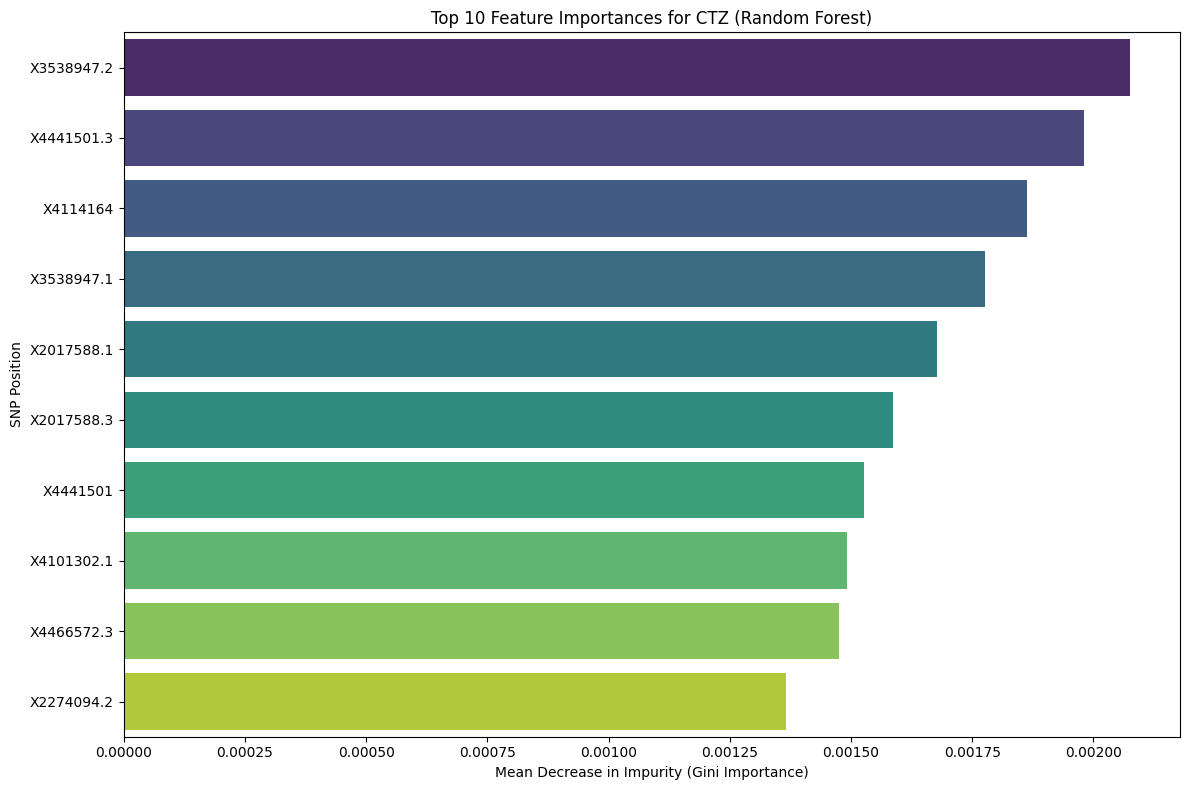


--- Explainability Analysis Complete ---
Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.


In [17]:
print("\n--- Random Forest Explainability: Feature Importances ---")

# Getting feature importances from the trained model
importances = rf_model.feature_importances_

# Creating a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'SNP_Position': snp_position_names,
    'Importance': importances
})

# Sorting the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# --- Displaying and Plotting Top Features ---
top_n = 10 # Number of top features to display
print(f"Top {top_n} most important SNP positions for predicting {TARGET_ANTIBIOTIC} resistance:")
print(feature_importance_df.head(top_n))

# Creating a bar plot of the top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Feature Importances for {TARGET_ANTIBIOTIC} (Random Forest)')
plt.xlabel('Mean Decrease in Impurity (Gini Importance)')
plt.ylabel('SNP Position')
plt.tight_layout()
plt.show()

print("\n--- Explainability Analysis Complete ---")
print("Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.")

# **GEN**

In [18]:
TARGET_ANTIBIOTIC = "GEN"

## **Initial Preprocessing**

In [19]:
print("\n--- Loading and Preprocessing Data ---")
try:
    snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
    pheno_df = pd.read_csv(PHENOTYPES_FILE)
except FileNotFoundError:
    print(f"ERROR: Ensure data files are in the correct Google Drive path.")
    exit()

print(f"Raw SNP matrix shape: {snp_df_raw.shape}")
print(f"Phenotypes shape: {pheno_df.shape}")

# Setting 'prename' as index for easy merging
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')

# Merging SNP data with phenotype data for the target antibiotic
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
print(f"Merged data shape: {merged_df.shape}")

# Handling potential NaN values
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)
print(f"Shape after dropping NaNs in target and filling NaNs in features: {merged_df.shape}")

# Separate features (SNPs) and labels
labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
features_df = merged_df.drop(columns=[TARGET_ANTIBIOTIC])

# Storing original SNP position names for explainability
snp_position_names = features_df.columns.tolist()

# Converting features to NumPy array
X = features_df.values.astype(np.int32)

print(f"Number of features (SNPs): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: Resistant (1): {np.sum(labels == 1)}, Susceptible (0): {np.sum(labels == 0)}")


--- Loading and Preprocessing Data ---
Raw SNP matrix shape: (809, 60937)
Phenotypes shape: (809, 5)
Merged data shape: (809, 60937)
Shape after dropping NaNs in target and filling NaNs in features: (809, 60937)
Number of features (SNPs): 60936
Number of samples: 809
Class distribution: Resistant (1): 188, Susceptible (0): 621


# **Data Splitting**

In [20]:
print("\n--- Splitting Data ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


--- Splitting Data ---
Training samples: 647
Test samples: 162


## **Model Definition & Training**

In [21]:
print("\n--- Defining and Training the Random Forest Model ---")

# --- Hyperparameter Selection based on Theoretical Knowledge ---
# n_estimators: The number of trees in the forest. 300-500 is a common choice.
n_estimators = 400

# For high-dimensional data, limiting depth prevents individual trees from overfitting, so I went with that.
max_depth = 15

# max_features: The number of features to consider when looking for the best split.
max_features = 'sqrt'

class_weight = 'balanced'

# n_jobs: Number of jobs to run in parallel. -1 means using all available CPU cores.
n_jobs = -1

# --- Model Instantiation ---
rf_model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features,
    class_weight=class_weight,
    n_jobs=n_jobs,
    random_state=42,
    oob_score=True # Using out-of-bag samples to estimate generalization accuracy
)

print(f"Training Random Forest with {n_estimators} trees and max_depth={max_depth}...")
rf_model.fit(X_train, y_train)

# --- Out-of-Bag Score ---
print(f"\nModel Out-of-Bag (OOB) Score: {rf_model.oob_score_:.4f}")

# --- SAVING THE FINAL MODEL ---
RF_MODEL_PATH = "best_RF_model_GEN.pkl"
print(f"Saving the final Random Forest model to {RF_MODEL_PATH}...")
joblib.dump(rf_model, RF_MODEL_PATH)
print("Model saved successfully.")


--- Defining and Training the Random Forest Model ---
Training Random Forest with 400 trees and max_depth=15...

Model Out-of-Bag (OOB) Score: 0.7759
Saving the final Random Forest model to best_RF_model_GEN.pkl...
Model saved successfully.


# **Model Evaluation**


--- Evaluating Random Forest Model on Test Set ---

Overall Performance Metrics (Test Set):
Accuracy: 0.7469
AUC Score: 0.7556
Cohen's Kappa: 0.3260
Matthews Correlation Coefficient (MCC): 0.3271

Classification Report:
                 precision    recall  f1-score   support

Susceptible (0)     0.8487    0.8145    0.8313       124
  Resistant (1)     0.4651    0.5263    0.4938        38

       accuracy                         0.7469       162
      macro avg     0.6569    0.6704    0.6626       162
   weighted avg     0.7588    0.7469    0.7521       162


Confusion Matrix:


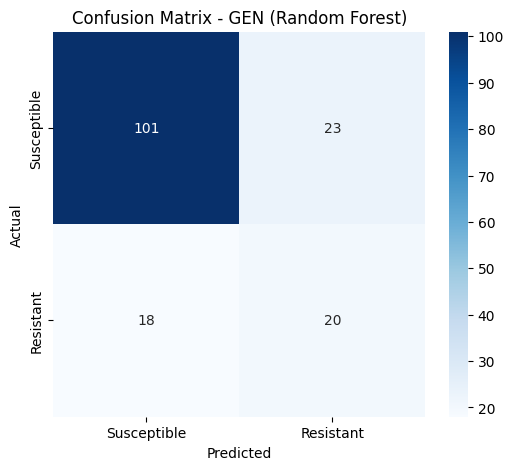

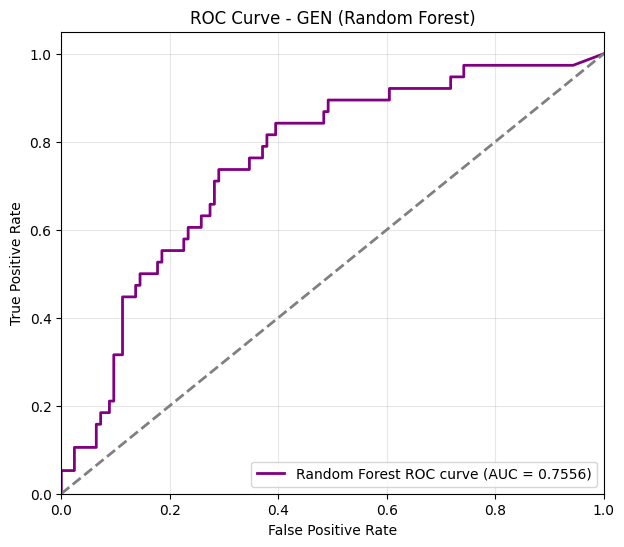

In [22]:
print("\n--- Evaluating Random Forest Model on Test Set ---")

# --- Making Predictions ---
y_pred_rf = rf_model.predict(X_test)
y_pred_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# --- Calculating All Metrics ---
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_probs_rf)
kappa_rf = cohen_kappa_score(y_test, y_pred_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print(f"\nOverall Performance Metrics (Test Set):")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"AUC Score: {auc_rf:.4f}")
print(f"Cohen's Kappa: {kappa_rf:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_rf:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
report = classification_report(y_test, y_pred_rf, target_names=["Susceptible (0)", "Resistant (1)"], digits=4)
print(report)

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Susceptible", "Resistant"],
            yticklabels=["Susceptible", "Resistant"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.show()

# --- ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_probs_rf)
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest ROC curve (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Random Forest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **Interpretation**


--- Random Forest Explainability: Feature Importances ---
Top 10 most important SNP positions for predicting GEN resistance:
      SNP_Position  Importance
13423     X4172893    0.002312
29264   X4477553.1    0.001819
45476   X4441501.2    0.001624
38183   X2435798.2    0.001518
13195     X4114164    0.001472
54039   X2540434.3    0.001449
42401     X3642836    0.001449
8012      X2540434    0.001430
40155   X2957424.2    0.001371
29093   X4441501.1    0.001363


/tmp/ipython-input-1486057161.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')


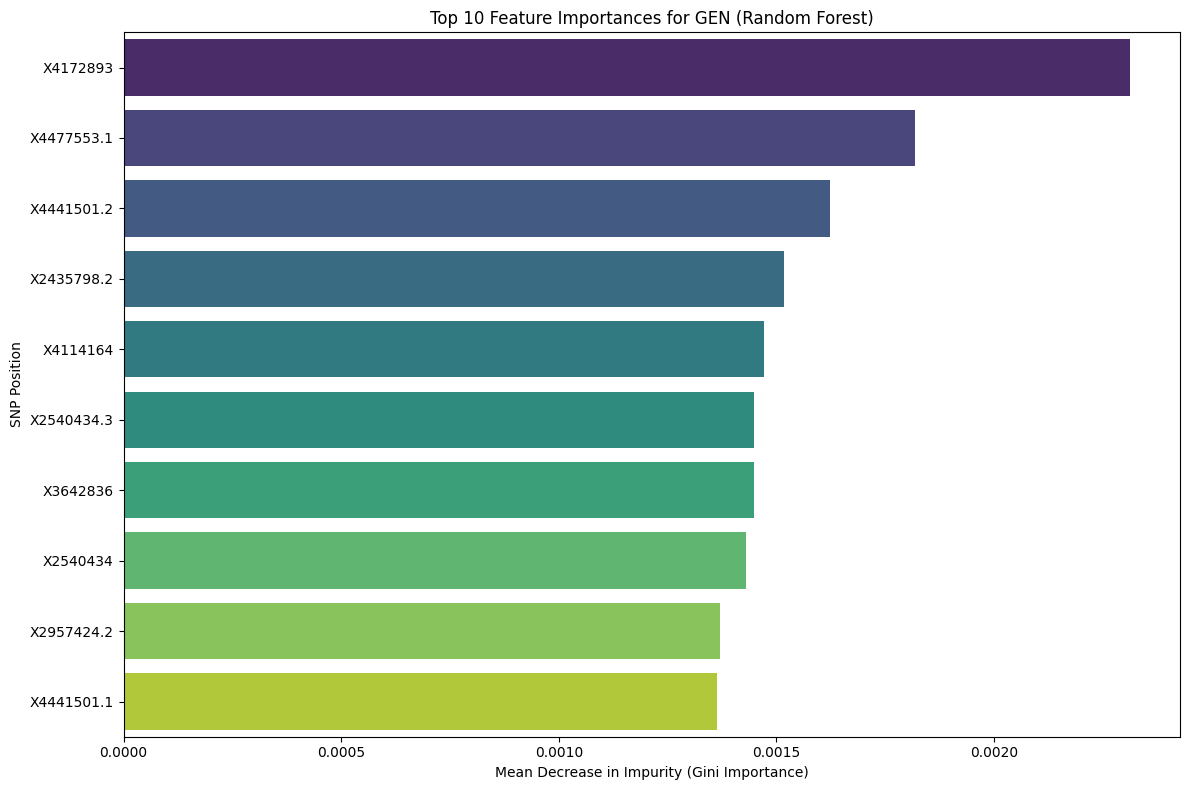


--- Explainability Analysis Complete ---
Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.


In [23]:
print("\n--- Random Forest Explainability: Feature Importances ---")

# Getting feature importances from the trained model
importances = rf_model.feature_importances_

# Creating a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({
    'SNP_Position': snp_position_names,
    'Importance': importances
})

# Sorting the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# --- Displaying and Plotting Top Features ---
top_n = 10 # Number of top features to display
print(f"Top {top_n} most important SNP positions for predicting {TARGET_ANTIBIOTIC} resistance:")
print(feature_importance_df.head(top_n))

# Creating a bar plot of the top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='SNP_Position', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Feature Importances for {TARGET_ANTIBIOTIC} (Random Forest)')
plt.xlabel('Mean Decrease in Impurity (Gini Importance)')
plt.ylabel('SNP Position')
plt.tight_layout()
plt.show()

print("\n--- Explainability Analysis Complete ---")
print("Consider using BLAST with the reference genome and the top SNP positions to identify associated genes.")